## 3. Fundamental_Empty
基本面选股，如果到在MA40以下，保持空仓。

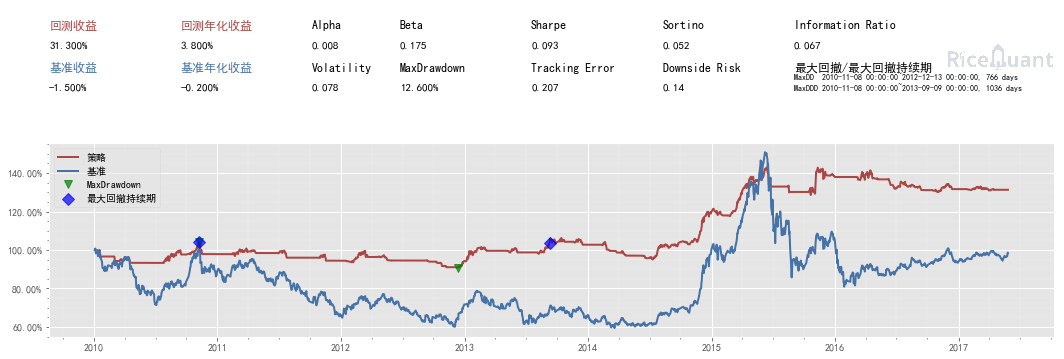

In [1]:
#coding=utf-8
# run_code_demo
from rqalpha import run_code

code = """
import numpy as np
import talib as ta
import pandas as pd
import os
import rqalpha
from rqalpha.api import *
from fxdayu_data import DataAPI


def init(context):
    DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/Valuation_Selection/config.py')
    df = DataAPI.candle('sh000001', 'D')
    df['MA_hedge'] = ta.abstract.MA(df, 40)
    context.df = df
    codes = pd.read_excel('D:/PycharmProjects/Quant_Alpha/Data_Manager/Valuation_Selection/Value_Selection.xlsx')
    codes.index = codes.pop('date')
    context.codes = codes


def find_pool(context, date):
    codes = context.codes.loc[date]
    stocks = codes.index[codes == True]
    return stocks


def handle_bar(context, bar_dict):
    sell(context)
    if can_trade(context):
        buy(context, bar_dict)


def buy(context, bar_dict):
    pool = find_pool(context, context.now)
    if pool is not None:
        stocks_len = len(pool)

    for stocks in context.portfolio.positions:
        if stocks not in pool:
            order_target_percent(stocks, 0)
    result = []
    for codes in pool:
        data_c = history_bars(codes, 25, '1d', 'close', adjust_type='post')
        ma = ta.MA(data_c, timeperiod=20)
        if len(ma) > 3 and context.df.close.loc[context.now] > context.df.MA_hedge.loc[context.now]:
            if ma[-1] > ma[-2] and ma[-2] > ma[-3] and codes not in result and codes not in context.portfolio.positions:
                result.append(codes)

    if len(result):
        for r in result:
            order_target_percent(r, 1.0 / stocks_len)


def sell(context):
    sell_list = []
    for stocks in context.portfolio.positions:
        data_c = history_bars(stocks, 25, '1d', 'close', adjust_type='post')
        ma = ta.MA(data_c, timeperiod=20)
        if len(ma) > 3:
            if (ma[-1] < ma[-2] and ma[-2] < ma[-3]):
                sell_list.append(stocks)
    # print('sell_list:', sell_list)
    if len(sell_list):
        for s in sell_list:
            order_target_percent(s, 0)


def sell_all(context):
    for stock in context.portfolio.positions:
        order_target_percent(stock, 0)


def can_trade(context):
    if context.df.close.loc[context.now] < context.df.MA_hedge.loc[context.now]:
        sell_all(context)
        return False
    else:
        return True
"""

config = {
  "base": {
    "start_date": "2010-01-04",
    "end_date": "2017-05-30",
    "securities": ['stock'],
    "stock_starting_cash": 100000,
    "benchmark": "000300.XSHG"
#     "strategy_file_path": os.path.abspath(__file__)
  },
  "extra": {
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

# 您可以指定您要传递的参数
run_code(code, config)